# code_2_MFGP_2 MFK with noisy observations
* Author: Songho Lee
* PI: Seunghwa Ryu
* References
    - https://github.com/SMTorg/smt/tree/master/tutorial#readme
    - https://colab.research.google.com/github/SMTorg/smt/blob/master/tutorial/MultiFi/SMT_MFK_Noise.ipynb

In [1]:
# ! pip install smt

# Forrester function
- Forrester, A., Sobester, A., & Keane, A. (2008). Engineering design via surrogate modelling: a practical guide. Wiley. 

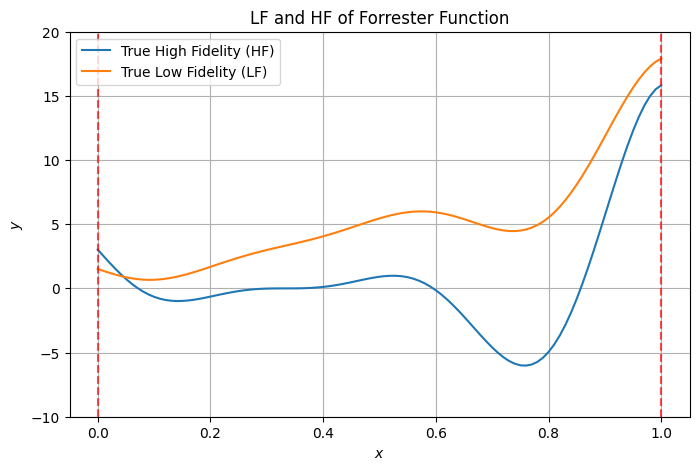

In [2]:
from smt.applications import MFK
import numpy as np
from matplotlib import pyplot as plt
from smt.applications.mfk import NestedLHS
from smt.surrogate_models import KRG
%matplotlib inline

def HF_function(x): # Forrester function
    return ((x * 6 - 2) ** 2) * np.sin((x * 6 - 2) * 2)
def LF_function(x):
    return 0.5 * ((x * 6 - 2) ** 2) * np.sin((x * 6 - 2) * 2) + (x - 0.5) * 10.0 + 5

x = np.linspace(0, 1, 101, endpoint=True).reshape(-1, 1)
y_hf = HF_function(x)
y_lf = LF_function(x)

fig, ax = plt.subplots(figsize=(8,5))
ax.plot(x, y_hf, label="True High Fidelity (HF)")
ax.plot(x, y_lf, label="True Low Fidelity (LF)")
ax.axvline(x=0, linestyle="--", color="r", linewidth=1.5, alpha=0.7)
ax.axvline(x=1, linestyle="--", color="r", linewidth=1.5, alpha=0.7)
ax.set_xlabel(r"$x$")
ax.set_ylabel(r"$y$")
ax.set_title("LF and HF of Forrester Function")
ax.legend(loc='upper left')
ax.grid(True)
ax.set_ylim([-10,20])
plt.show()
plt.close()

# Sampling

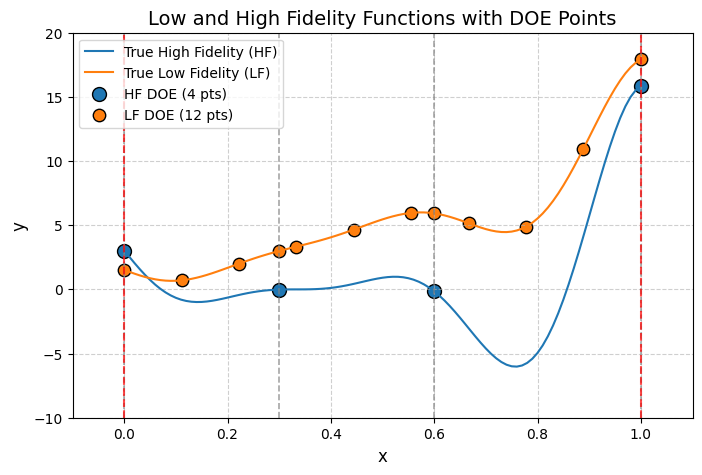

In [3]:
# Define x values and evaluate functions
x = np.linspace(0, 1, 101, endpoint=True).reshape(-1, 1)

# Expensive DOE with 4 points
Xt_e = np.array([0.0, 0.3, 0.6, 1.0]).reshape(-1, 1)
# Cheap DOE with 12 points
Xt_c = np.linspace(1 / 9, 8 / 9, 8, endpoint=True).reshape(-1, 1)
Xt_c = np.concatenate((Xt_c, Xt_e), axis=0)  # Ensure nesting

# Evaluate the HF and LF functions
yt_e = HF_function(Xt_e)
yt_c = LF_function(Xt_c)


# Plot
fig, ax = plt.subplots(figsize=(8, 5))
ax.plot(x, y_hf, label="True High Fidelity (HF)")
ax.plot(x, y_lf, label="True Low Fidelity (LF)")
ax.scatter(Xt_e, yt_e, color="C0", edgecolor="k", s=100, label="HF DOE (4 pts)")
ax.scatter(Xt_c, yt_c, color="C1", edgecolor="k", s=80, label="LF DOE (12 pts)")
for xe in Xt_e:
    ax.axvline(x=xe, linestyle="--", color="gray", linewidth=1.2, alpha=0.7)
ax.axvline(x=0, linestyle="--", color="r", linewidth=1.5, alpha=0.7)
ax.axvline(x=1, linestyle="--", color="r", linewidth=1.5, alpha=0.7)
ax.set_xlabel("x", fontsize=12)
ax.set_ylabel("y", fontsize=12)
ax.set_title("Low and High Fidelity Functions with DOE Points", fontsize=14)
ax.legend(loc="upper left", fontsize=10)
ax.grid(True, linestyle="--", alpha=0.6)
ax.set_xlim(-0.1, 1.1)
ax.set_ylim(-10, 20)
plt.show()
plt.close()

# MFK with given noise variance parameters 

In [4]:
# MFK
yt_joint = np.concatenate((yt_c, yt_e))
noise0 = [
    np.array(
        [
            2e-01,
            7e-02,
            2e-03,
            6e-08,
            5e-02,
            5e-02,
            4e-02,
            3e-02,
            2e-01,
            1e-02,
            5e-06,
            1e-01,
        ]
    )
    / 2,
    np.array([1.5, 0.4, 0.01, 0.1]) / 5,
]
theta0 = np.array([[0.5], [0.1]])
np.random.seed(7)
sm = MFK(
    theta0=theta0,
    theta_bounds=[1e-1, 20],
    noise0=noise0,
    use_het_noise=True,
    propagate_uncertainty=False,
    n_start=1,
)

sm.set_training_values(Xt_c, yt_c, name=0)
sm.set_training_values(Xt_e, yt_e)
sm.train()

ntest = 101
nlvl = len(sm.X)
x = np.linspace(0, 1, ntest, endpoint=True).reshape(-1, 1)
y = sm.predict_values(x)
var = sm.predict_variances(x)
y0 = sm._predict_intermediate_values(x, 1)
var0, _ = sm.predict_variances_all_levels(x)
var0 = var0[:, 0].reshape(-1, 1)


# SFK
theta0 = sm.options["theta0"]
noise0 = sm.options["noise0"]

sm_monoHF = MFK(
    theta0=theta0[1].tolist(),
    theta_bounds=[1e-1, 20],
    noise0=[noise0[1]],
    use_het_noise=True,
    n_start=1,
)
sm_monoHF.set_training_values(Xt_e, yt_e)
sm_monoHF.train()
y_monoHF = sm_monoHF.predict_values(x)
var_monoHF = sm_monoHF.predict_variances(x)

sm_monoLF = MFK(
    theta0=theta0[0].tolist(),
    theta_bounds=[1e-1, 20],
    noise0=[noise0[0]],
    use_het_noise=True,
    n_start=1,
)
sm_monoLF.set_training_values(Xt_c, yt_c)
sm_monoLF.train()
y_monoLF = sm_monoLF.predict_values(x)
var_monoLF = sm_monoLF.predict_variances(x)



___________________________________________________________________________
   
                                    MFK
___________________________________________________________________________
   
 Problem size
   
      # training points.        : 4
   
___________________________________________________________________________
   
 Training
   
   Training ...
   Training - done. Time (sec):  0.0319991
___________________________________________________________________________
   
 Evaluation
   
      # eval points. : 101
   
   Predicting ...
   Predicting - done. Time (sec):  0.0009964
   
   Prediction time/pt. (sec) :  0.0000099
   
___________________________________________________________________________
   
                                    MFK
___________________________________________________________________________
   
 Problem size
   
      # training points.        : 4
   
___________________________________________________________________________
   
 Training
 

C:\Users\Desktop_M4_7\anaconda3\envs\py310smt\lib\site-packages\smt\applications\mfk.py:990: UserWarning: TNC not available yet for noise handling. Switching to Cobyla
  warnings.warn(
C:\Users\Desktop_M4_7\anaconda3\envs\py310smt\lib\site-packages\smt\applications\mfk.py:990: UserWarning: TNC not available yet for noise handling. Switching to Cobyla
  warnings.warn(
C:\Users\Desktop_M4_7\anaconda3\envs\py310smt\lib\site-packages\smt\applications\mfk.py:990: UserWarning: TNC not available yet for noise handling. Switching to Cobyla
  warnings.warn(


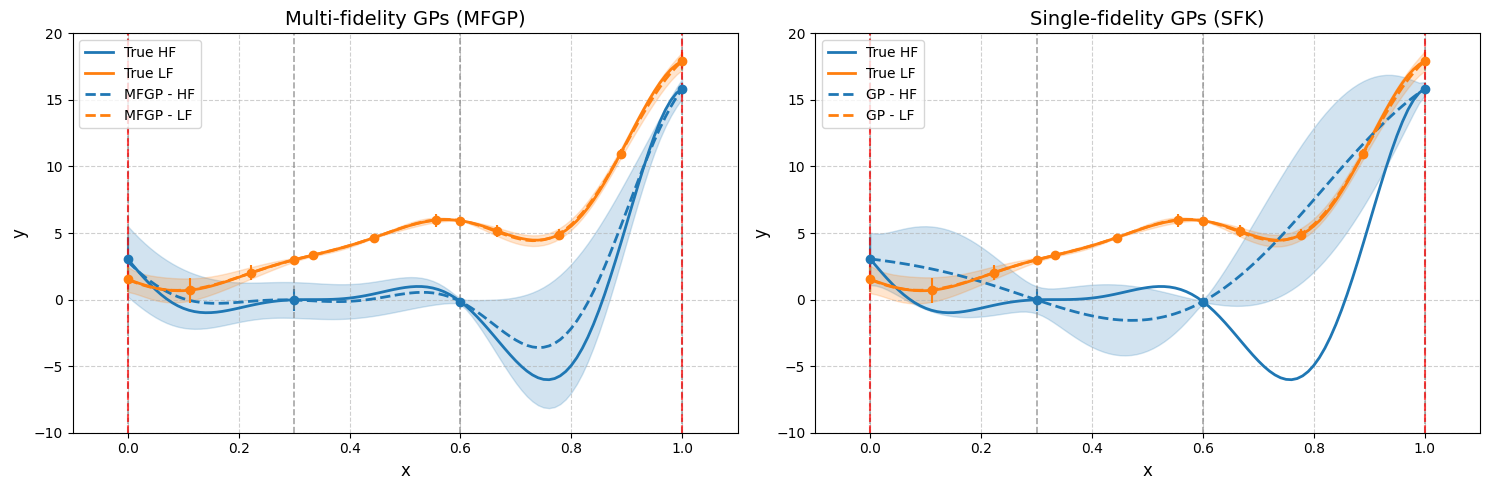

In [5]:
fig, axs = plt.subplots(1, 2, figsize=(15, 5))

# 첫 번째 서브플롯: Multi-fidelity GPs (MFGP)
ax = axs[0]
ax.plot(x, HF_function(x), "-", label="True HF", color="C0", linewidth=2)
ax.plot(x, LF_function(x), "-", label="True LF", color="C1", linewidth=2)

# Multi-fidelity GPs 예측
ax.plot(x, y, "--", label="MFGP - HF", color="C0", linewidth=2)
ax.fill_between(
    np.ravel(x),
    np.ravel(y - 3 * np.sqrt(var)),
    np.ravel(y + 3 * np.sqrt(var)),
    color="C0",
    alpha=0.2,
    # label="Confidence Interval 99% HF",
)
ax.plot(x, y0, "--", label="MFGP - LF", color="C1", linewidth=2)
ax.fill_between(
    np.ravel(x),
    np.ravel(y0 - 3 * np.sqrt(var0)),
    np.ravel(y0 + 3 * np.sqrt(var0)),
    color="C1",
    alpha=0.2,
    # label="Confidence Interval 99% LF",
)

# Error bars for DOE
ax.errorbar(
    np.squeeze(Xt_e),
    np.squeeze(yt_e),
    yerr=np.squeeze(3 * np.sqrt(noise0[-1])),
    fmt="o",
    color="C0",
    # label="HF DOE",
)
ax.errorbar(
    np.squeeze(Xt_c),
    np.squeeze(yt_c),
    yerr=np.squeeze(3 * np.sqrt(noise0[0])),
    fmt="o",
    color="C1",
    # label="LF DOE",
)

for xe in Xt_e:
    ax.axvline(x=xe, linestyle="--", color="gray", linewidth=1.2, alpha=0.7)
ax.axvline(x=0, linestyle="--", color="r", linewidth=1.5, alpha=0.7)
ax.axvline(x=1, linestyle="--", color="r", linewidth=1.5, alpha=0.7)

ax.set_xlim(-0.1, 1.1)
ax.set_ylim(-10, 20)
ax.set_xlabel("x", fontsize=12)
ax.set_ylabel("y", fontsize=12)
ax.set_title("Multi-fidelity GPs (MFGP)", fontsize=14)
ax.legend(loc="upper left", fontsize=10)
ax.grid(True, linestyle="--", alpha=0.6)



# 두 번째 서브플롯: Single-fidelity GPs (SFK)
ax = axs[1]
ax.plot(x, HF_function(x), "-", label="True HF", color="C0", linewidth=2)
ax.plot(x, LF_function(x), "-", label="True LF", color="C1", linewidth=2)

# Single-fidelity GPs 예측
ax.plot(x, y_monoHF, "--", label="GP - HF", color="C0", linewidth=2)
ax.fill_between(
    np.ravel(x),
    np.ravel(y_monoHF - 3 * np.sqrt(var_monoHF)),
    np.ravel(y_monoHF + 3 * np.sqrt(var_monoHF)),
    color="C0",
    alpha=0.2,
    # label="Confidence Interval 99% HF",
)
ax.plot(x, y_monoLF, "--", label="GP - LF", color="C1", linewidth=2)
ax.fill_between(
    np.ravel(x),
    np.ravel(y_monoLF - 3 * np.sqrt(var_monoLF)),
    np.ravel(y_monoLF + 3 * np.sqrt(var_monoLF)),
    color="C1",
    alpha=0.2,
    # label="Confidence Interval 99% LF",
)

# Error bars for DOE
ax.errorbar(
    np.squeeze(Xt_e),
    np.squeeze(yt_e),
    yerr=np.squeeze(3 * np.sqrt(noise0[-1])),
    fmt="o",
    # color="C0",
)
ax.errorbar(
    np.squeeze(Xt_c),
    np.squeeze(yt_c),
    yerr=np.squeeze(3 * np.sqrt(noise0[0])),
    fmt="o",
    # color="C1",
)

for xe in Xt_e:
    ax.axvline(x=xe, linestyle="--", color="gray", linewidth=1.2, alpha=0.7)
ax.axvline(x=0, linestyle="--", color="r", linewidth=1.5, alpha=0.7)
ax.axvline(x=1, linestyle="--", color="r", linewidth=1.5, alpha=0.7)

ax.set_xlim(-0.1, 1.1)
ax.set_ylim(-10, 20)
ax.set_xlabel("x", fontsize=12)
ax.set_ylabel("y", fontsize=12)
ax.set_title("Single-fidelity GPs (SFK)", fontsize=14)
ax.legend(loc="upper left", fontsize=10)
ax.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()
plt.close()

# MFK with repetitions of observations

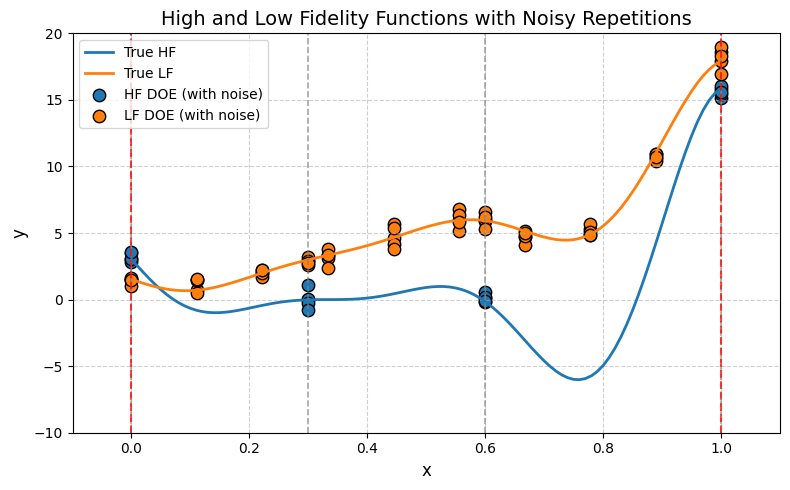

In [6]:
# adding noisy repetitions
Xt_c_reps = Xt_c.copy()
yt_c_reps = yt_c.copy()
Xt_e_reps = Xt_e.copy()
yt_e_reps = yt_e.copy()

for i in range(4):
    Xt_c_reps = np.concatenate((Xt_c_reps, Xt_c))
    Xt_e_reps = np.concatenate((Xt_e_reps, Xt_e))
    np.random.seed(i)
    yt_c_reps = np.concatenate(
        (yt_c_reps, yt_c + 0.1 * np.std(yt_c) * np.random.normal(size=yt_c.shape))
    )
    yt_e_reps = np.concatenate(
        (yt_e_reps, yt_e + 0.1 * np.std(yt_e) * np.random.normal(size=yt_e.shape))
    )


fig, ax = plt.subplots(figsize=(8, 5))
ax.plot(x, HF_function(x), "-", label="True HF", color="C0", linewidth=2)
ax.plot(x, LF_function(x), "-", label="True LF", color="C1", linewidth=2)

ax.scatter(Xt_e_reps, yt_e_reps, color="C0", edgecolor="k", s=80, label="HF DOE (with noise)")
ax.scatter(Xt_c_reps, yt_c_reps, color="C1", edgecolor="k", s=80, label="LF DOE (with noise)")

for xe in Xt_e:
    ax.axvline(x=xe, linestyle="--", color="gray", linewidth=1.2, alpha=0.7)
ax.axvline(x=0, linestyle="--", color="r", linewidth=1.5, alpha=0.7)
ax.axvline(x=1, linestyle="--", color="r", linewidth=1.5, alpha=0.7)

ax.set_xlim(-0.1, 1.1)
ax.set_ylim(-10, 20)
ax.set_xlabel("x", fontsize=12)
ax.set_ylabel("y", fontsize=12)
ax.set_title("High and Low Fidelity Functions with Noisy Repetitions", fontsize=14)
ax.legend(loc="upper left", fontsize=10)
ax.grid(True, linestyle="--", alpha=0.6)

# Show the plot
plt.tight_layout()
plt.show()
plt.close()

In [7]:
# MFK
yt_joint = np.concatenate((yt_c_reps, yt_e_reps))
theta0 = np.array([[0.5], [0.1]])
np.random.seed(7)
sm = MFK(
    theta0=theta0,
    noise0=noise0,
    eval_noise=True,
    use_het_noise=True,
    propagate_uncertainty=False,
    n_start=1,
)

sm.set_training_values(Xt_c_reps, yt_c_reps, name=0)
sm.set_training_values(Xt_e_reps, yt_e_reps)
sm.train()

# test
y = sm.predict_values(x)
var = sm.predict_variances(x)
y0 = sm._predict_intermediate_values(x, 1)
var0, _ = sm.predict_variances_all_levels(x)
var0 = var0[:, 0].reshape(-1, 1)

___________________________________________________________________________
   
                                    MFK
___________________________________________________________________________
   
 Problem size
   
      # training points.        : 20
   
___________________________________________________________________________
   
 Training
   
   Training ...
   Training - done. Time (sec):  0.0155032
___________________________________________________________________________
   
 Evaluation
   
      # eval points. : 101
   
   Predicting ...
   Predicting - done. Time (sec):  0.0000000
   
   Prediction time/pt. (sec) :  0.0000000
   


C:\Users\Desktop_M4_7\anaconda3\envs\py310smt\lib\site-packages\smt\applications\mfk.py:990: UserWarning: TNC not available yet for noise handling. Switching to Cobyla
  warnings.warn(


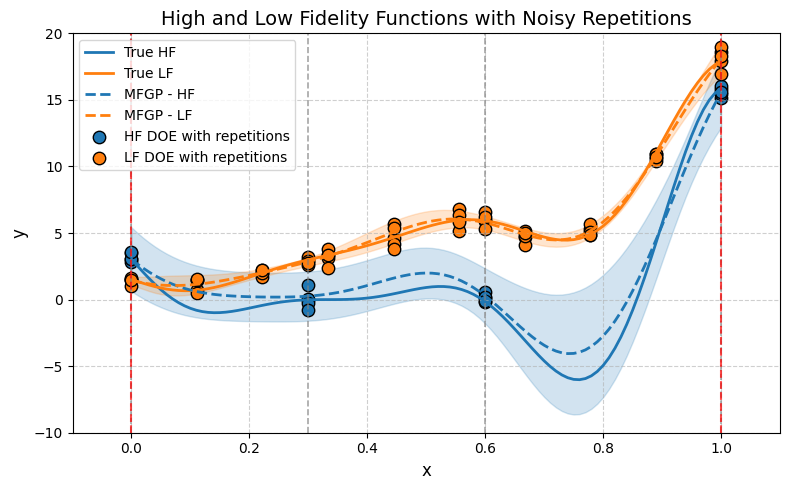

In [8]:
fig, ax = plt.subplots(figsize=(8, 5))
ax.plot(x, HF_function(x), "-", label="True HF", color="C0", linewidth=2)
ax.plot(x, LF_function(x), "-", label="True LF", color="C1", linewidth=2)

# Multi-fidelity GPs prediction
ax.plot(x, y, "--", label="MFGP - HF", color="C0", linewidth=2)
ax.fill_between(
    np.ravel(x),
    np.ravel(y - 3 * np.sqrt(var)),
    np.ravel(y + 3 * np.sqrt(var)),
    color="C0",
    alpha=0.2,
    # label="Confidence Interval 99% HF",
)
ax.plot(x, y0, "--", label="MFGP - LF", color="C1", linewidth=2)
ax.fill_between(
    np.ravel(x),
    np.ravel(y0 - 3 * np.sqrt(var0)),
    np.ravel(y0 + 3 * np.sqrt(var0)),
    color="C1",
    alpha=0.2,
    # label="Confidence Interval 99% LF",
)

ax.scatter(Xt_e_reps, yt_e_reps, color="C0", edgecolor="k", s=80, label="HF DOE with repetitions")
ax.scatter(Xt_c_reps, yt_c_reps, color="C1", edgecolor="k", s=80, label="LF DOE with repetitions")

for xe in Xt_e:
    ax.axvline(x=xe, linestyle="--", color="gray", linewidth=1.2, alpha=0.7)
ax.axvline(x=0, linestyle="--", color="r", linewidth=1.5, alpha=0.7)
ax.axvline(x=1, linestyle="--", color="r", linewidth=1.5, alpha=0.7)

ax.set_xlim(-0.1, 1.1)
ax.set_ylim(-10, 20)
ax.set_xlabel("x", fontsize=12)
ax.set_ylabel("y", fontsize=12)
ax.set_title("High and Low Fidelity Functions with Noisy Repetitions", fontsize=14)
ax.legend(loc="upper left", fontsize=10)
ax.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()
plt.close()